In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from scipy.signal.windows import dpss
import sys
# Lambda_idx = int(sys.argv[1])
# nbins = int(sys.argv[3])
Lambda_idx = 24
nbins = 100

Lambda = Lambdas[Lambda_idx]

In [2]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)


# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

In [28]:
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, nbins)
print(oup_fname)

/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_3.50000_zmax_8.10000_Lambda_idx_24_from_quad_nbins_100.npy


In [14]:
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), nbins + 1)
eHIeHI_binned = np.zeros((nbins,nbins), dtype=np.float64)

In [15]:
dchi = np.mean(np.diff(chi_bin_edges))

In [16]:
from scipy.integrate import quad, dblquad

In [17]:
import mpmath as mpm

In [21]:
def compute_bin_element(params):
    i, j, l1, r1, l2, r2, dchi, Lambda, chimin, chimax = params
    
    eIeI = 0
    if i == j:
        center = (l1 + r1) / 2
        eIeI = f_eIeI(chi=center, dchi=dchi, Lambda=Lambda)
    
    cross, _ = dblquad(
        lambda x, xp: f_cross(x, xp, Lambda=Lambda),
        l1, r1, l2, r2,
        epsabs=0.0,
        epsrel=1e-8
    )
    cross = cross / dchi**2
    
    LOLO, _ = dblquad(
        lambda x, xp: f_eLOeLO_scipy(
            chi=x,
            chip=xp,
            chimin=chimin,
            chimax=chimax,
            Lambda=Lambda
        ),
        l1, r1, l2, r2,
        epsabs=0.0,
        epsrel=1e-8
    )
    LOLO = LOLO / dchi**2
    
    return (i, j, eIeI - cross + LOLO)


In [26]:
eHIeHI_oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_log2_%d_nbins_%d.npy'%(zmin, zmax, Lambda_idx, 13, nbins)
old_eHIeHI_binned = np.load(eHIeHI_oup_fname)

In [22]:
params_list = []
for i, (l1, r1) in enumerate(zip(chi_bin_edges[:-1], chi_bin_edges[1:])):
    for j, (l2, r2) in enumerate(zip(chi_bin_edges[:-1], chi_bin_edges[1:])):
        params = (i, j, l1, r1, l2, r2, dchi, Lambda, chimin, chimax)
        params_list.append(params)


In [23]:
with Pool(processes=32) as pool:
        results = list(tqdm(
            pool.imap(compute_bin_element, params_list),
            total=len(params_list)
        ))

100%|██████████| 10000/10000 [03:51<00:00, 43.15it/s]


In [24]:
for i, j, value in results:
        eHIeHI_binned[i, j] = value

In [29]:
np.save(oup_fname, eHIeHI_binned)

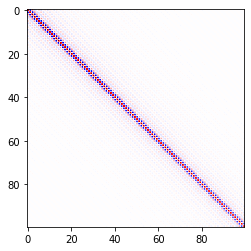

In [25]:
vb = np.max(np.abs(eHIeHI_binned))
plt.imshow(eHIeHI_binned, vmin = -vb, vmax = vb, cmap = 'seismic')

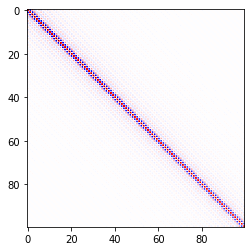

In [27]:
vb = np.max(np.abs(eHIeHI_binned))
plt.imshow(old_eHIeHI_binned, vmin = -vb, vmax = vb, cmap = 'seismic')